In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [2]:
infile = 'data/fitted_model_object_semi_markov.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 1 / 30.

In [3]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,10,0,0,-0.059584,-0.055408
1,11,0,0,-1.109823,-0.981042
2,10,1,0,-0.059933,-0.055732
3,11,1,4,-1.857872,-2.135831
4,10,2,0,-0.059719,-0.055534


In [4]:
gpm.Xframe.head()

,X0
0,0
1,0
2,0
3,0
4,0


# Plot inferred categories as matrix

In [5]:
xi = gpm.nodes['HMM'].nodes['z'].z[1]
T, K = xi.shape
print xi.shape

(512644, 10)


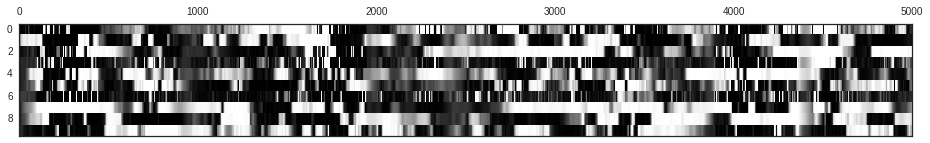

In [6]:
matshow(xi[:5000].T, vmin=0, vmax=1);

Make $\xi$ dataframe:

In [7]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

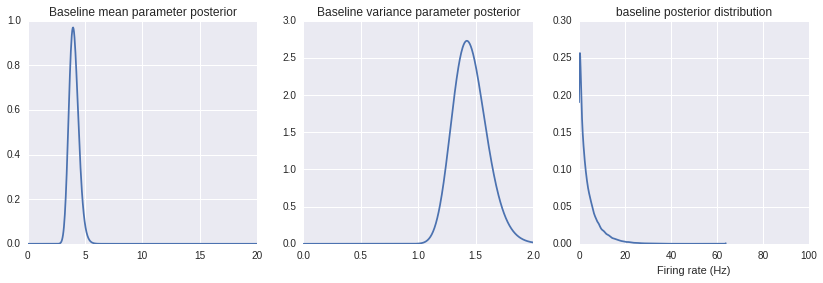

In [8]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 2, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

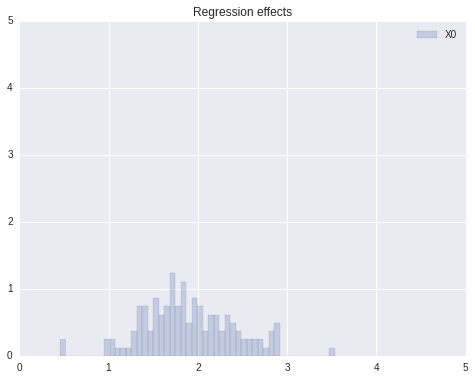

In [9]:
plt.figure(figsize=(8, 6))
inferred_means = gpm.nodes['fr_regressors'].expected_x()
R = inferred_means.shape[1]
for r in xrange(R):
    plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
plt.title('Regression effects');
plt.legend()
plt.ylim(0, 5);
plt.xlim(0, 5);

## Latent Categories

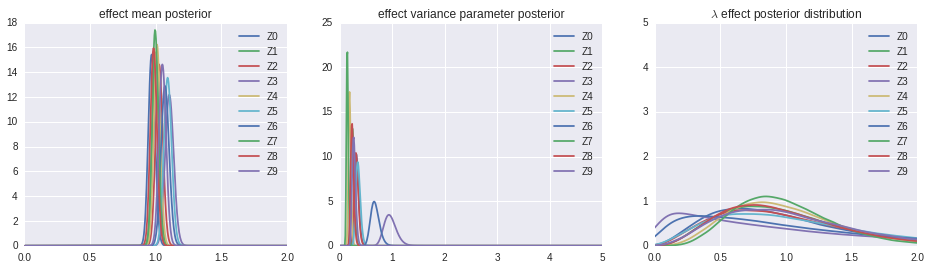

In [10]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

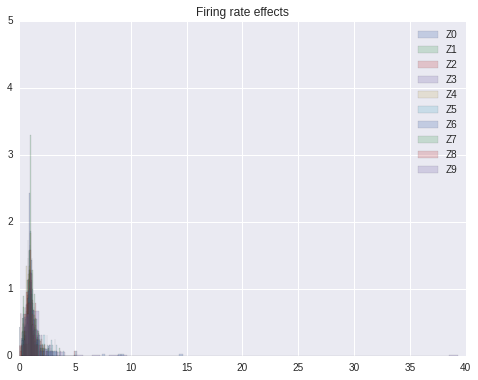

In [11]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

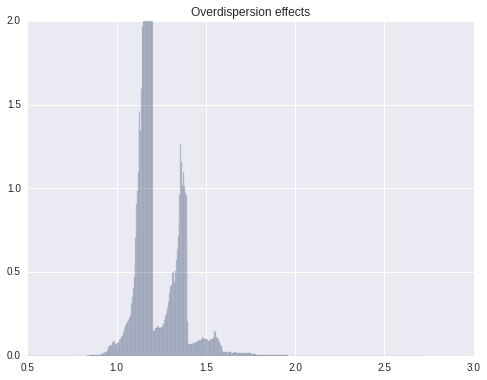

In [12]:
plt.figure(figsize=(8, 6))

inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
plt.title('Overdispersion effects');
plt.ylim(0, 2);

# Load and prepare ethogram:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [13]:
ethofile = 'sql/etho.csv'
etho = pd.read_csv(ethofile)

/home/pearson/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [14]:
# rename some columns
etho = etho.rename(columns={'movieId': 'movie', 'frameNumber': 'frame'})
etho = frames_to_times(etho)

In [15]:
etho.head()

,frameTime,ethoCameraLabel,ethoCameraLevel,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoRoughCountLabel,...,ethoChase,ethoFlee,ethoThreaten,ethoMountedThreaten,ethoSubmit,ethoDisplace,ethoLeanAway,ethoAvoid,ethoBranchDisplay,time
0,0.0000,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0333,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0667,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0.1000,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0.1333,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [16]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(etho, xif, how='right')
edf.columns

Index([u'frameTime', u'ethoCameraLabel', u'ethoCameraLevel', u'ethoCameraHolding', u'ethoCameraZoomingIn', u'ethoCameraZoomingOut', u'ethoCameraTracking', u'ethoCameraPanning', u'ethoCameraSlewing', u'ethoRoughCountLabel', u'ethoRoughCountLevel', u'ethoCountNone', u'ethoLeast1', u'ethoLeast2', u'ethoLeast3', u'ethoLeast6', u'ethoLeast11', u'ethoHumanVisible', u'ethoFaceLabel', u'ethoFaceViewLevel', u'ethoFaceNone', u'ethoFaceVisible', u'ethoFaceProminent', u'ethoFaceDirect', u'ethoFaceEyeContact', u'ethoGenitalsLabel', u'ethoGenitalsViewLevel', u'ethoGenitalsNone', u'ethoGenitalsVisible', u'ethoGenitalsProminent', u'ethoGenitalsMale', u'ethoGenitalsFemale', u'ethoGenitalsBoth', u'ethoForageLabel', u'ethoForageLevel', u'ethoForage', u'ethoMassForage', u'ethoDrink', u'ethoSearch', u'ethoGraspFood', u'ethoHoldFood', u'ethoHoldInMouth', u'ethoManipulateFood', u'ethoIngestFood', u'ethoIngestFromGroom', u'ethoChew', u'ethoRetrieveFromPouch', u'ethoHeave', u'ethoAllogroom', u'ethoSolicitAllog

In [17]:
# get rid of categories that are either identifiers or have non-binary entries
edf = edf.drop(['frameTime', 'ethoCameraLabel', 'ethoFaceLabel',
                'ethoGenitalsLabel', 'ethoForageLabel', 'ethoAggressionLabel', 'time',
                'ethoCameraLevel',
                'ethoRoughCountLabel', 'ethoRoughCountLevel', 'ethoFaceViewLevel', 
                'ethoGenitalsViewLevel', 'ethoForageLevel', 'ethoAggressionLevel'], axis=1)


In [18]:
edf.head()

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
0,1,0,0,0,0,0,1,0,0,0,...,0.000869,0.113425,0.011768,0.036095,0.022329,0.022412,0.036863,0.041385,0.035811,0.029422
1,1,0,0,0,0,0,1,0,0,0,...,0.000339,0.131789,0.023052,0.039152,0.029461,0.045409,0.039120,0.045370,0.041550,0.049875
2,1,0,0,0,0,0,1,0,0,0,...,0.006991,0.201935,0.024809,0.049215,0.039698,0.059990,0.058066,0.054545,0.052797,0.074910
3,1,0,0,0,0,0,1,0,0,0,...,0.012789,0.280873,0.027265,0.064405,0.051773,0.072728,0.084334,0.067040,0.066743,0.095601
4,1,0,0,0,0,0,1,0,0,0,...,0.017441,0.361247,0.029621,0.080075,0.064323,0.082964,0.112222,0.081425,0.081808,0.112544


# View results:

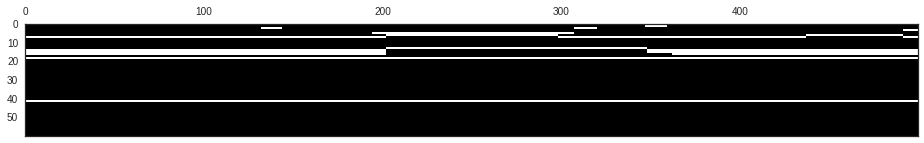

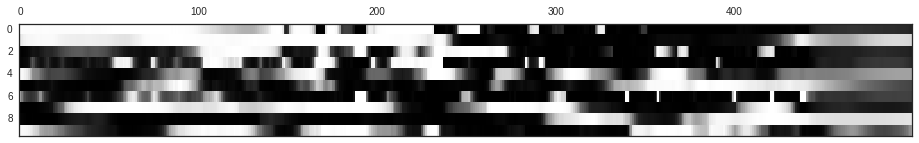

In [19]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [20]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

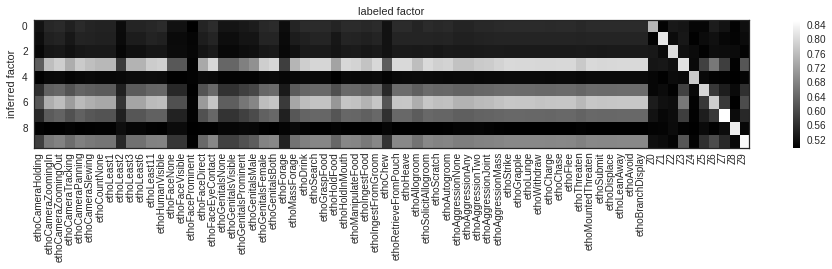

In [21]:
row_labels = edf.columns[:]
matshow(overlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [22]:
overlap.iloc[-K:, :]

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.526991,0.554999,0.558929,0.547051,0.559640,0.550802,0.548406,0.548406,0.515584,0.550818,...,0.754878,0.504933,0.533563,0.530328,0.508890,0.509015,0.539816,0.525906,0.504781,0.522141
Z1,0.518824,0.544658,0.549705,0.533287,0.548952,0.548703,0.546630,0.546630,0.514247,0.540080,...,0.504933,0.821300,0.515997,0.532169,0.502673,0.515496,0.523195,0.510672,0.506629,0.516199
Z2,0.510270,0.531148,0.533546,0.524542,0.532633,0.536121,0.536215,0.536215,0.509503,0.523491,...,0.533563,0.515997,0.808528,0.523209,0.515633,0.503319,0.518232,0.517421,0.515649,0.505605
Z3,0.630867,0.765886,0.787318,0.741068,0.782306,0.767209,0.756756,0.756756,0.581809,0.751650,...,0.530328,0.532169,0.523209,0.815836,0.513543,0.592047,0.667334,0.586391,0.503603,0.619913
Z4,0.502107,0.511657,0.512625,0.506183,0.510548,0.513931,0.510674,0.510674,0.511757,0.516511,...,0.508890,0.502673,0.515633,0.513543,0.783862,0.513607,0.504420,0.503459,0.500169,0.506327
Z5,0.564965,0.635244,0.643066,0.616325,0.639864,0.633026,0.627928,0.627928,0.546224,0.627150,...,0.509015,0.515496,0.503319,0.592047,0.513607,0.798774,0.579419,0.541591,0.514286,0.567804
Z6,0.620534,0.743289,0.764281,0.720047,0.759302,0.744273,0.734678,0.734678,0.573947,0.730155,...,0.539816,0.523195,0.518232,0.667334,0.504420,0.579419,0.786000,0.579728,0.501494,0.606370
Z7,0.558448,0.627603,0.639232,0.615564,0.637045,0.621620,0.616119,0.616119,0.546715,0.620004,...,0.525906,0.510672,0.517421,0.586391,0.503459,0.541591,0.579728,0.856645,0.516975,0.555766
Z8,0.505463,0.500418,0.500134,0.505222,0.500815,0.502381,0.504135,0.504135,0.520858,0.509488,...,0.504781,0.506629,0.515649,0.503603,0.500169,0.514286,0.501494,0.516975,0.833223,0.510713
Z9,0.588912,0.668610,0.682310,0.651894,0.678708,0.668698,0.664398,0.664398,0.557439,0.659960,...,0.522141,0.516199,0.505605,0.619913,0.506327,0.567804,0.606370,0.555766,0.510713,0.850199


Try using the MPM (maximizer of posterior marginals) rather than the posterior:

In [23]:
# round to 0 or 1 elementwise
medf = np.around(edf)

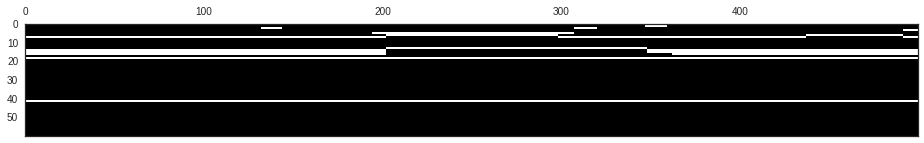

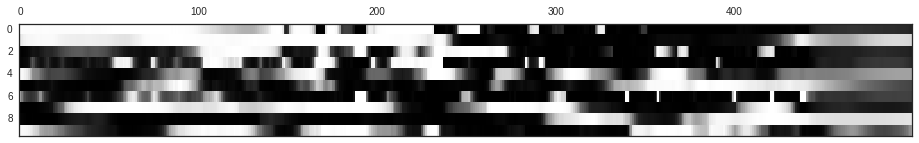

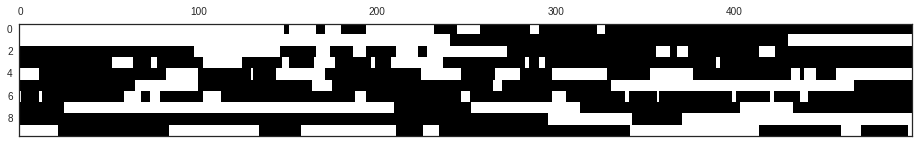

In [24]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

In [25]:
mmatch = (medf.T.dot(medf) + (1 - medf.T).dot(1 - medf)) / T
mmismatch = (medf.T.dot(1 - medf) + (1 - medf.T).dot(medf)) / T
moverlap = np.maximum(mmatch, mmismatch)

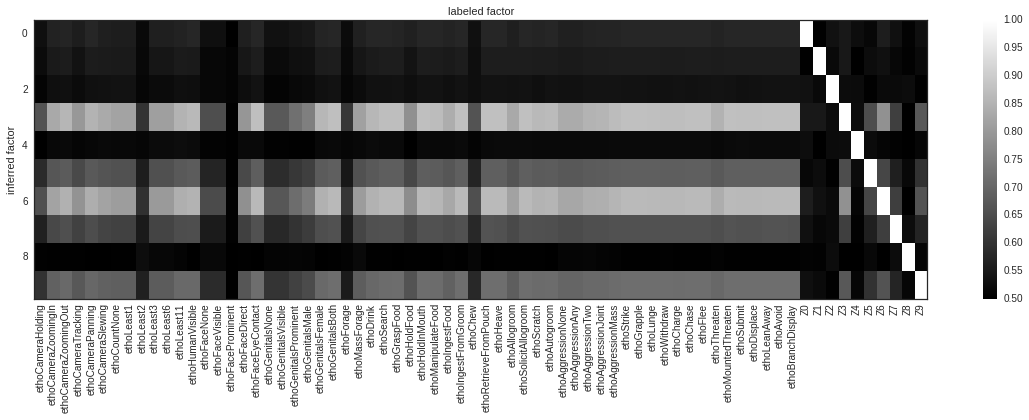

In [26]:
row_labels = medf.columns[:]
matshow(moverlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');
plt.gcf().set_size_inches([20, 5])

In [27]:
moverlap.iloc[-K:, :]

,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,ethoLeast3,...,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.531041,0.567801,0.572998,0.556710,0.574307,0.560970,0.558276,0.558276,0.518996,0.561692,...,1.000000,0.503382,0.533721,0.547477,0.526264,0.514363,0.557168,0.532978,0.507247,0.530399
Z1,0.521916,0.551178,0.556183,0.536310,0.555592,0.554642,0.552124,0.552124,0.515773,0.544448,...,0.503382,1.000000,0.518085,0.547048,0.501014,0.523480,0.532902,0.515137,0.504703,0.521208
Z2,0.509410,0.529371,0.532340,0.522977,0.531507,0.535013,0.535592,0.535592,0.513676,0.521662,...,0.533721,0.518085,1.000000,0.525066,0.522813,0.502341,0.521227,0.520991,0.524879,0.502585
Z3,0.662620,0.830848,0.856979,0.798322,0.851909,0.832751,0.820148,0.820148,0.600099,0.811235,...,0.547477,0.547048,0.525066,1.000000,0.523796,0.650604,0.783292,0.624654,0.500437,0.672781
Z4,0.501828,0.515984,0.518001,0.510577,0.515603,0.519436,0.515701,0.515701,0.513557,0.522753,...,0.526264,0.501014,0.522813,0.523796,1.000000,0.522497,0.510539,0.505477,0.500837,0.512352
Z5,0.582256,0.668501,0.678036,0.645854,0.674472,0.664537,0.658781,0.658781,0.557266,0.657066,...,0.514363,0.523480,0.502341,0.650604,0.522497,1.000000,0.638092,0.562431,0.515925,0.599599
Z6,0.657969,0.820064,0.847444,0.789567,0.840400,0.820540,0.808506,0.808506,0.595004,0.800967,...,0.557168,0.532902,0.521227,0.783292,0.510539,0.638092,1.000000,0.621989,0.501100,0.663870
Z7,0.563465,0.642134,0.655004,0.628483,0.652310,0.634093,0.628516,0.628516,0.551958,0.632927,...,0.532978,0.515137,0.520991,0.624654,0.505477,0.562431,0.621989,1.000000,0.524241,0.573599
Z8,0.505243,0.503646,0.503119,0.502768,0.501927,0.500969,0.502836,0.502836,0.525661,0.515420,...,0.507247,0.504703,0.524879,0.500437,0.500837,0.515925,0.501100,0.524241,1.000000,0.513672
Z9,0.599279,0.691189,0.707341,0.673064,0.702985,0.690409,0.685721,0.685721,0.564930,0.680168,...,0.530399,0.521208,0.502585,0.672781,0.512352,0.599599,0.663870,0.573599,0.513672,1.000000


In [28]:
moverlap.iloc[-K:, :-K].max()

ethoCameraHolding        0.662620
ethoCameraZoomingIn      0.830848
ethoCameraZoomingOut     0.856979
ethoCameraTracking       0.798322
ethoCameraPanning        0.851909
ethoCameraSlewing        0.832751
ethoCountNone            0.820148
ethoLeast1               0.820148
ethoLeast2               0.600099
ethoLeast3               0.811235
ethoLeast6               0.811235
ethoLeast11              0.853230
ethoHumanVisible         0.861686
ethoFaceNone             0.653206
ethoFaceVisible          0.653206
ethoFaceProminent        0.508579
ethoFaceDirect           0.793287
ethoFaceEyeContact       0.873181
ethoGenitalsNone         0.674376
ethoGenitalsVisible      0.674376
ethoGenitalsProminent    0.720108
ethoGenitalsMale         0.749058
ethoGenitalsFemale       0.857755
ethoGenitalsBoth         0.874113
ethoForage               0.607488
ethoMassForage           0.814497
ethoDrink                0.858524
ethoSearch               0.871410
ethoGraspFood            0.872344
ethoHoldFood  

In [29]:
mi_mat = mutual_information_matrix(edf.iloc[:, :-K].values, edf.iloc[:, -K:].values)

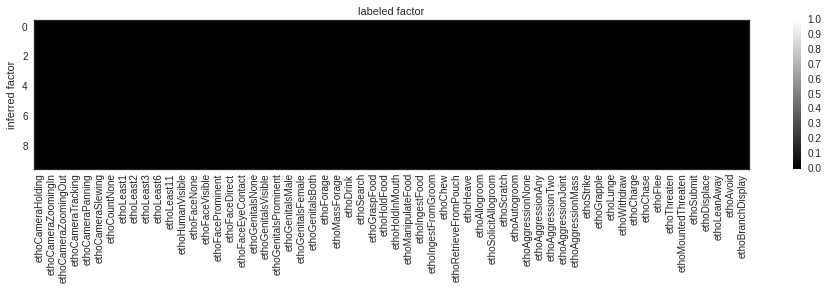

In [30]:
row_labels = edf.columns[:-K]
matshow(mi_mat.T, vmin=0, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

### What is chance overlap?

How much overlap should we expect by chance, simply based on raw statistics? Let's generate some sequences from the fitted model and look at their overlap.

In [31]:
A = gpm.nodes['HMM'].nodes['A']
pi = gpm.nodes['HMM'].nodes['pi']
dnode = gpm.nodes['HMM'].nodes['d']

In [32]:
def get_duration(mu, lam, shape, rate):
    """
    Given tuple of normal-gamma parameters, draw a duration (max = D) from
    the appropriate lognormal distribution.
    """
    while True:
        d = lognormal_from_hypers(mu, lam, shape, rate, 1)
        if (d >= 1) and (d <= gpm.D):
            break
    
    return d

In [33]:
def make_chain(A, pi, mu, lam, shape, rate):
    """
    Generate a latent state sequence. A and pi are Markov parameters. Other
    arguments specify normal-gamma hyperparameters to a lognormal duration 
    distribution.
    """

    chain = np.empty((T,))

    # initialize
    t = 0
    while t < T:
        if t == 0:
            pp = pi[1]
        else:
            pp = A[1, chain[t - 1]]

        # pick a new state
        z = stats.bernoulli.rvs(pp, size=1)

        # pick a duration
        d = get_duration(mu[z], lam[z], shape[z], rate[z]).astype('int')
        d = np.min([d, gpm.T - d])

        # fill in the next d steps of the chain
        chain[t:(t+d)] = z
        t += d
            
    return chain

In [34]:
def generate_fake_chains(nfake):
    fakechains = np.empty((T, K * nfake))

    for kk in xrange(K):

        # draw nfake transition matrices from posterior
        fakeA = np.empty(A.post.shape[:2] + (nfake,))
        for idx in xrange(fakeA.shape[1]):
            fakeA[:, idx, :] = stats.dirichlet.rvs(A.post[:, idx, kk], size=nfake).T

        # same for pi
        fakepi = np.empty(pi.post.shape[:1] + (nfake,))
        fakepi = stats.dirichlet.rvs(pi.post[..., kk], size=nfake).T

        # get poster parameters for duration distribution
        mu = dnode.parent.post_mean[:, kk]
        lam = dnode.parent.post_scaling[:, kk]
        alpha = dnode.parent.post_shape[:, kk]
        beta = dnode.parent.post_rate[:, kk]

        for idx in xrange(nfake):
            fakechains[:, kk * nfake + idx] = make_chain(fakeA[..., idx], fakepi[..., idx], mu, lam, alpha, beta)

    return fakechains

In [35]:
%%time
nfake = 100  # number of fake sequences for each chain
fchains = generate_fake_chains(nfake)

CPU times: user 44min 50s, sys: 1.49 s, total: 44min 51s
Wall time: 44min 51s


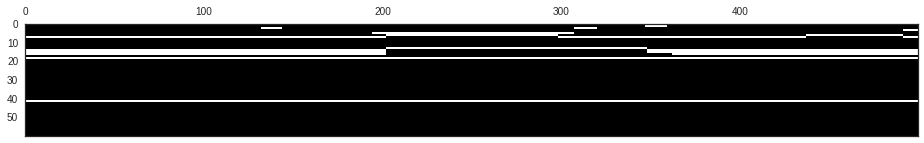

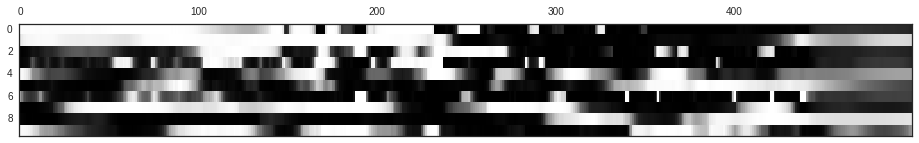

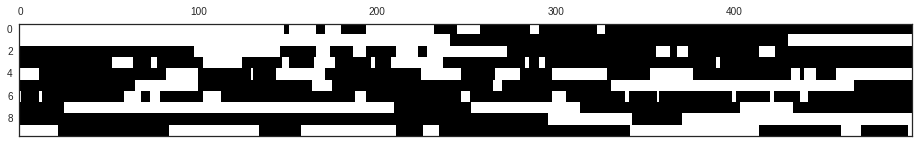

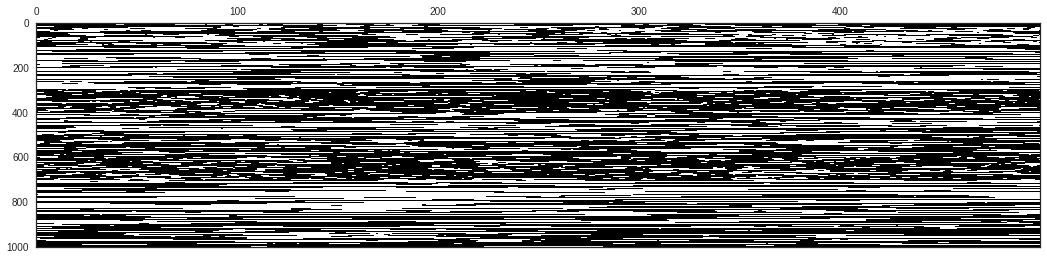

In [36]:
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use fake chains
matshow(fchains[trng].T, vmin=0, vmax=1);
plt.gcf().set_size_inches([18, 4])

Calculate overlap with actual ethogram:

In [37]:
fmatch = (edf.T.dot(fchains) + (1 - edf.T).dot(1 - fchains)) / T
fmismatch = (edf.T.dot(1 - fchains) + (1 - edf.T).dot(fchains)) / T
foverlap = np.maximum(fmatch, fmismatch)

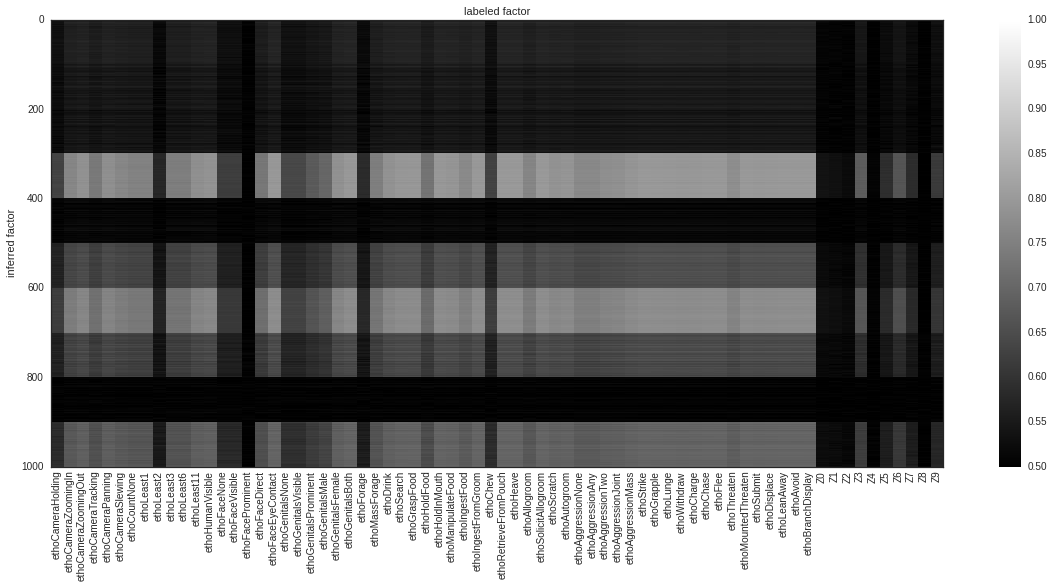

In [38]:
row_labels = edf.columns[:]
matshow(foverlap.values.T, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5);
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

plt.gcf().set_size_inches([20, 8])

In [39]:
foverlap.max(axis=1)

ethoCameraHolding        0.636385
ethoCameraZoomingIn      0.768126
ethoCameraZoomingOut     0.789965
ethoCameraTracking       0.743571
ethoCameraPanning        0.784946
ethoCameraSlewing        0.769944
ethoCountNone            0.759728
ethoLeast1               0.759728
ethoLeast2               0.580812
ethoLeast3               0.751812
ethoLeast6               0.751812
ethoLeast11              0.785452
ethoHumanVisible         0.792175
ethoFaceNone             0.626876
ethoFaceVisible          0.626876
ethoFaceProminent        0.516608
ethoFaceDirect           0.739027
ethoFaceEyeContact       0.802017
ethoGenitalsNone         0.648013
ethoGenitalsVisible      0.648013
ethoGenitalsProminent    0.684941
ethoGenitalsMale         0.707676
ethoGenitalsFemale       0.789946
ethoGenitalsBoth         0.802629
ethoForage               0.591206
ethoMassForage           0.752583
ethoDrink                0.790703
ethoSearch               0.800476
ethoGraspFood            0.800930
ethoHoldFood  

In [40]:
foverlap.mean(axis=1)

ethoCameraHolding        0.555646
ethoCameraZoomingIn      0.611343
ethoCameraZoomingOut     0.620193
ethoCameraTracking       0.600811
ethoCameraPanning        0.618439
ethoCameraSlewing        0.611758
ethoCountNone            0.607659
ethoLeast1               0.607659
ethoLeast2               0.532368
ethoLeast3               0.604323
ethoLeast6               0.604323
ethoLeast11              0.618642
ethoHumanVisible         0.621460
ethoFaceNone             0.551539
ethoFaceVisible          0.551539
ethoFaceProminent        0.503965
ethoFaceDirect           0.598647
ethoFaceEyeContact       0.625571
ethoGenitalsNone         0.560109
ethoGenitalsVisible      0.560109
ethoGenitalsProminent    0.575553
ethoGenitalsMale         0.585204
ethoGenitalsFemale       0.620175
ethoGenitalsBoth         0.625760
ethoForage               0.536681
ethoMassForage           0.604714
ethoDrink                0.620838
ethoSearch               0.624843
ethoGraspFood            0.625117
ethoHoldFood  

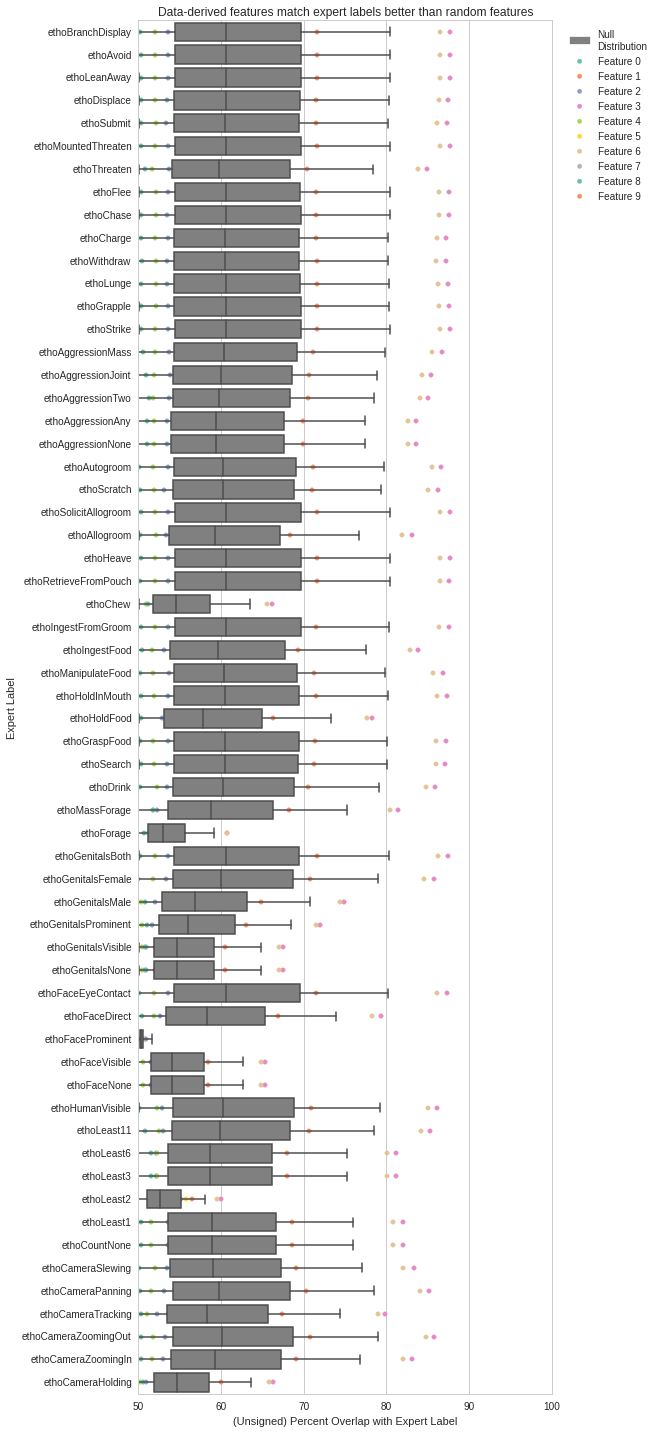

In [41]:
fov = foverlap.T.iloc[:, :-K] * 100
mov = moverlap.iloc[-K:, :-K] * 100
with sns.axes_style('whitegrid'):
    # plot data from the null distribution
    sns.boxplot(fov, vert=False, whis=1000, color='gray', label='Null\nDistribution')
    
    colors = sns.color_palette(name='Set2', n_colors=K)
    # plot data from fitted categories
    for idx in range(mov.shape[0]):
        dat = mov.iloc[idx].values
        label = 'Feature {}'.format(idx)
        plt.scatter(dat, np.arange(dat.size) + 1, color=colors[idx], label=label)
        
    plt.xlim(50, 100)
    plt.title('Data-derived features match expert labels better than random features')
    plt.xlabel('(Unsigned) Percent Overlap with Expert Label')
    plt.ylabel('Expert Label')
    plt.gcf().set_size_inches([8, 20])
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    plt.gcf().tight_layout()
    plt.savefig('overlap.svg')